In [205]:
# Imports
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
import numpy as np
import random
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

In [206]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [207]:
GloVe = {}
with open("glove.6B/glove.6B.100d.txt", "r", encoding="utf-8") as vector_file:
    for line in vector_file:
        line_content = line.split()
        word = line_content[0]
        # There's probably a better way to read strings into a FloatTensor
        word_vec = torch.from_numpy(np.asarray(line_content[1:], "float32"))
        GloVe[word] = word_vec

In [225]:
# Define Word Bank
word_bank = ["academy", "advance", "aircraft", "ally", "ammo", "ammunition", "armor", "arms", "army", "arrow", "arsenal", "artillery", "attack", "attention", "ballistic", "barracks", "base", "battalion", "battery", "battle", "battlefield", "bomb", "bombard", "bombardment", "brig", "brigade", "bullet", "camouflage", "camp", "cannon", "captain", "capture", "carrier", "casualty", "catapult", "cavalry", "colonel", "combat", "command", "commander", "commission", "company", "conflict", "conquest", "convoy", "corps", "covert", "crew", "decode", "defeat", "defend", "defense", "destroyer", "division", "draft", "encode", "enemy", "engage", "enlist", "evacuate", "explosive", "fight", "fire", "fleet", "force", "formation", "fort", "front", "garrison", "general", "grenade", "grunt", "guerrilla", "gun", "headquarters", "helmet", "honor", "hospital", "infantry", "injury", "intelligence", "invade", "invasion", "jet", "kill", "leave", "lieutenant", "major", "maneuver", "marines", "MIA", "mid", "military", "mine", "missile", "mortar", "navy", "neutral", "offense", "officer", "ordinance", "parachute", "peace", "plane", "platoon", "private", "radar", "rank", "recruit", "regiment", "rescue", "reserves", "retreat", "ribbon", "sabotage", "sailor", "salute", "section", "sergeant", "service", "shell", "shoot", "shot", "siege", "sniper", "soldier", "spear", "specialist", "squad", "squadron", "staff", "submarine", "surrender", "tactical", "tactics", "tank", "torpedo", "troops", "truce", "uniform", "unit", "veteran", "volley", "war", "warfare", "warrior", "weapon", "win", "wound"]

In [226]:
# Create Word Embeddings Matrix
wb_embeddings = torch.zeros((len(word_bank), 100))

for i, word in enumerate(word_bank):
    wb_embeddings[i] = GloVe[word.lower()]
    
wb_embeddings.size()

torch.Size([149, 100])

In [227]:
def dot_similarity_score(word_emb):
    similarities = torch.matmul(wb_embeddings, word_emb)
    return similarities

In [228]:
def calc_p_value(score, dist):
    score = float(score)
    distribution = dist.tolist()
    count = 0
    for val in distribution:
        if val >= score:
            count += 1
    emp_p = float(count) / NUM_SAMPLES
    return emp_p

In [229]:
def calculate_score(emb):
    sims = dot_similarity_score(emb).tolist()
    p = []
    
    for i, sim in enumerate(sims):
        p.append(calc_p_value(sim, dot_samples[i]))
    
    return np.mean(p) * 100

In [230]:
# Create background distributions
sample = 0
NUM_SAMPLES = 50000
vocab = list(GloVe.values())
dot_samples = torch.zeros((NUM_SAMPLES, len(word_bank)))

while sample < NUM_SAMPLES:
    word = random.choice(vocab)
    dot_vector = dot_similarity_score(word)
    dot_samples[sample] = dot_vector
    sample += 1
        
# Reshape so that it is indexable by word
dot_samples = dot_samples.reshape(len(word_bank), NUM_SAMPLES)

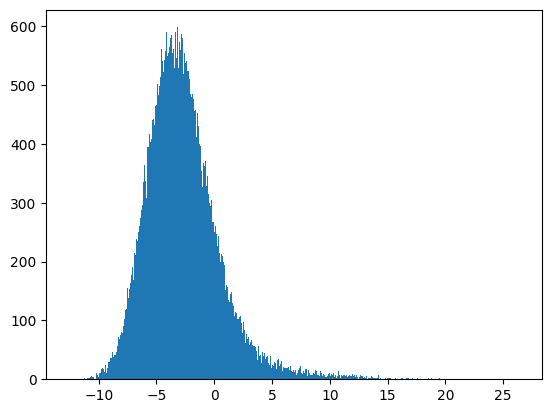

In [231]:
# Graph score count to check distributions
plt.hist(dot_samples[0].tolist(), bins = 500)
plt.show()

In [232]:
calculate_score(GloVe["military"])

0.9262953020134228

In [233]:
# new implementation, using GloVe vectors

# TODO: Custom Beam Search -- Keep n possibilities (beams) at each time
# then, accumulate a probability associated with each (normalize by length of generation)

# March 1st: Sampling, performance, normalization
prompt = "The issue focused"

print("Base GPT-2 Output:")

inputs = tokenizer(prompt, return_tensors="pt")
print(tokenizer.batch_decode(model.generate(**inputs, num_beams=3, do_sample=True, max_new_tokens=20, pad_token_id=50256)))

top_k_val = 5
NUM_TOK_TO_GEN = 40

# take positional argument for which index to pick
def generate_one(prompt_beam, idx):
    prompt = prompt_beam[0]
    score = prompt_beam[1]
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"])
    #print(outputs)
    loss = outputs.loss
    logits = outputs.logits
    next_token_scores = logits[:, -1, :].softmax(dim=-1)

    sorted_vals, indices = torch.sort(next_token_scores[0])
    sorted_vals = sorted_vals[-top_k_val:]
    indices = indices[-top_k_val:]

    #print([tokenizer.decode(word) for word in indices])
    # one of the generated words is blank (ACTUALLY \n)
    top_embeddings = []
    for word_idx in range(len(indices)):
        word = tokenizer.decode(indices[word_idx])
        if word.strip().lower() not in GloVe.keys():
            sorted_vals[word_idx] = 0  # disregard this token
            #print(f'word: {word}')
            top_embeddings.append(GloVe['failure'])
        else:
            if word[1:].isalpha() or word.isalpha():
                top_embeddings.append(GloVe[word.strip().lower()])
            else:
                # TODO: getting here with 'A' or 'I'
                top_embeddings.append(GloVe[word.strip()])


    #top_embeddings = [GloVe[tokenizer.decode(word).strip().lower()] for word in indices]
    #print(top_embeddings)

    dist_score = [calculate_score(embed) for embed in top_embeddings]
    #print(dist_score)

    hyper_weight = .5

    pre_rerank = sorted_vals.detach().clone()
    # re-rank the weightings, factor in dist_score
    for i in range(len(sorted_vals)):
        if dist_score[i] == 0:
            # avoid division by 0 (exact match)
            sorted_vals[i] = 0
        else:
            sorted_vals[i] += (1/dist_score[i])*hyper_weight

    sort_indices = torch.argsort(sorted_vals)
    final_ranked_indices = [indices[s] for s in sort_indices]

    # replace -1 with -idx for true beam search
    # add variability instead for true decoding (TODO)
    # TODO normalization
    
    best_word = tokenizer.decode(final_ranked_indices[-idx])
    prompt += best_word
    s_vals = sorted_vals[sort_indices]
    # add normalization by length
    # remove 'score +' here, and add normalization
    return [prompt, score + s_vals[-idx].detach().numpy()]


def beam_search(num_beams, tokens_to_generate):
    beams = [[prompt, 0]]

    #for token_num in range(NUM_TOK_TO_GEN):

    for token_num in range(tokens_to_generate):
        num_to_investigate = len(beams)
        for beam_idx in range(num_to_investigate):
            prompt_beam = beams[beam_idx]
            for position in range(num_beams):
                ret = generate_one(prompt_beam, position)
                beams.append(ret)
        # or normalize scores by length here
        beams = sorted(beams, key=lambda x: -x[1])
        #print(beams)
        beams = beams[:num_beams]
        #print(beams)
    return beams

result = beam_search(2, 20)
print('Custom Output: ')
print(result[0][0])


Base GPT-2 Output:
['The issue focused on the possibility of a "long-term solution" to the problem of climate change.\n\n']
Custom Output: 
The issue focused on the use of force by the military to stop an attack on an American military base in Iraq.


In [223]:
torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]) - torch.tensor([0, 1, 2])

tensor([[0, 0, 0],
        [3, 3, 3],
        [6, 6, 6],
        [9, 9, 9]])